# Experimento 2 - Órdenes Conflictivas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../..")

import pickle
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Use latex
plt.rc("text", usetex=True)

## Generación

Generación de instancias:

In [7]:
from src.generacion import (
    GeneradorInstancias,
    DistribucionIndependiente,
    DistribucionUniforme,
    DistribucionNormal,
)

random.seed(42)

# Generar instancias
N = 1000

generador = GeneradorInstancias(
    cantidad_trabajadores=DistribucionUniforme(5, 10),
    cantidad_ordenes=DistribucionUniforme(5, 20),
    parametros_ordenes=DistribucionIndependiente(
        DistribucionNormal(10000, 2000),
        DistribucionUniforme(3, 10),
    ),
    cantidad_ordenes_conflictivas=DistribucionUniforme(5, 20),
)

instancias = [generador.generar_instancia() for _ in range(N)]

with open("datos/instancia.pkl", "wb") as f:
    pickle.dump(instancias, f)

In [3]:
from typing import List
from src.instancia import InstanciaAsignacionCuadrillas


with open("datos/instancia.pkl", "rb") as f:
    instancias: List[InstanciaAsignacionCuadrillas] = pickle.load(f)

## Resolución

Resolución:

In [11]:
from tqdm import tqdm
from src.modelo import ModeloAsignacionCuadrillas
from src.solver import ConfiguracionCPLEX


soluciones = []
for instancia in tqdm(instancias):
    modelo = ModeloAsignacionCuadrillas(instancia)
    solver = modelo.armar_solver(ConfiguracionCPLEX(sin_output=True))

    objetivo, valores = solver.resolver()

    anotada = modelo.anotar_solucion(valores)

    soluciones.append((objetivo, anotada))

with open("datos/solucion.pkl", "wb") as f:
    pickle.dump(soluciones, f)

100%|██████████| 1000/1000 [11:24<00:00,  1.46it/s] 


In [4]:
from typing import List
from src.solucion import SolucionAnotada


with open("datos/solucion.pkl", "rb") as f:
    soluciones: List[SolucionAnotada] = pickle.load(f)

### Distribución de Función Objetivo

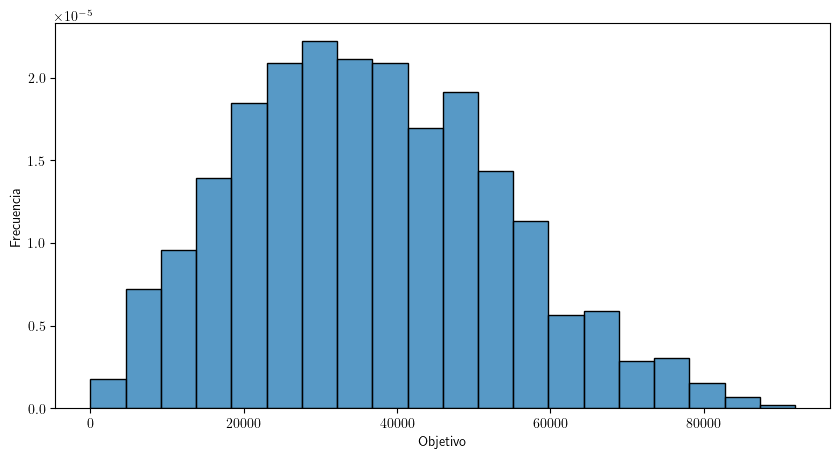

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

optimos = [obj for (obj, _) in soluciones]
sns.histplot(optimos, bins=20, ax=ax, stat="density")

ax.set_xlabel("Objetivo")
ax.set_ylabel("Frecuencia")

# Save
plt.savefig("graficos/distribucion_objetivo.pdf")

plt.show()

In [6]:
pd.Series(optimos).describe()

count     1000.000000
mean     36521.254557
std      17078.298788
min          0.000000
25%      23664.782282
50%      35407.594574
75%      48465.470096
max      91928.223369
dtype: float64

### Comparación con Distribución Anterior

In [7]:
with open("../exp1/datos/solucion.pkl", "rb") as f:
    soluciones_exp1: List[SolucionAnotada] = pickle.load(f)

optimos_exp1 = pd.Series([obj for (obj, _) in soluciones_exp1])
optimos_exp2 = pd.Series(optimos)

In [8]:
from scipy import stats


stats.ttest_ind(optimos_exp1, optimos_exp2, equal_var=False)

TtestResult(statistic=np.float64(2.036391557560313), pvalue=np.float64(0.041842675237193566), df=np.float64(1997.9850381013741))

### Proporción

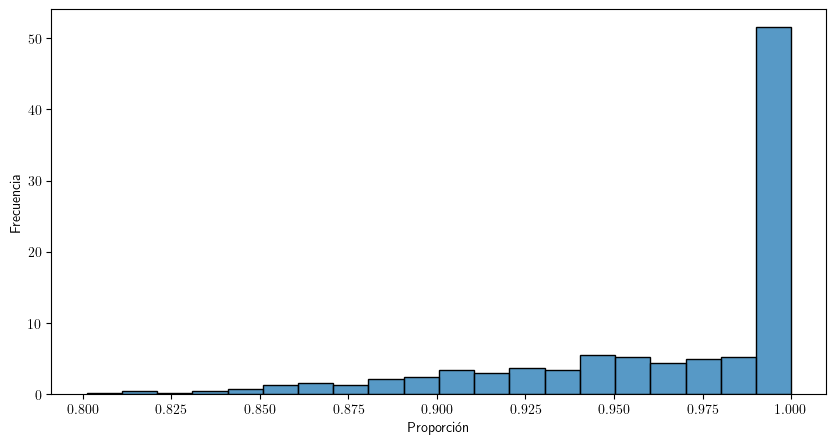

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

proporciones_optimo_ajustado = [
    obj / instancia.bmp_realizables()
    for instancia, (obj, _) in zip(instancias, soluciones)
    if instancia.bmp_realizables() > 0
]

sns.histplot(proporciones_optimo_ajustado, bins=20, ax=ax, stat="density")

ax.set_xlabel("Proporción")
ax.set_ylabel("Frecuencia")

# Save
plt.savefig("graficos/distribucion_proporcion_objetivo.pdf")

plt.show()

### Distribución de Cantidad y Proporción de Órdenes

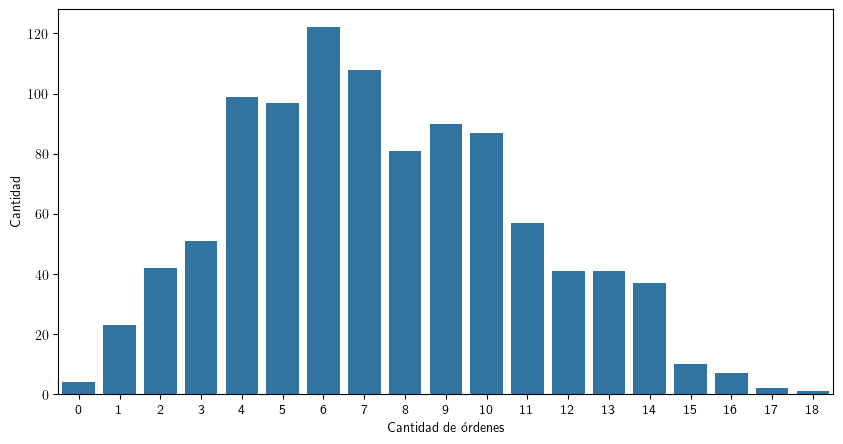

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

cantidad_ordenes = [
    solucion.cantidad_de_ordenes_realizadas() for (_, solucion) in soluciones
]

counts = pd.Series(cantidad_ordenes).value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax)

ax.set_xlabel("Cantidad de órdenes")
ax.set_ylabel("Cantidad")

# Save
plt.savefig("graficos/distribucion_cantidad_ordenes.pdf")

plt.show()

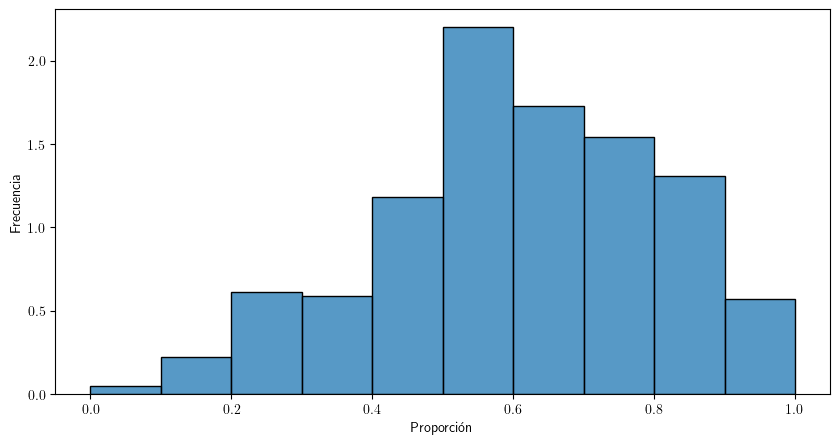

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

proporcion_ordenes = [
    len(solucion.ordenes_realizadas) / len(instancia.ordenes)
    for instancia, (_, solucion) in zip(instancias, soluciones)
]

sns.histplot(proporcion_ordenes, bins=10, ax=ax, stat="density")

ax.set_xlabel("Proporción")
ax.set_ylabel("Frecuencia")

# Save
plt.savefig("graficos/distribucion_proporcion_ordenes.pdf")

plt.show()